# Steam Games Rating Prediction
In this exploration notebook, we will demonstrate the entire pipeline of our project.

First, we import external libraries along with the dataset that will be used throughout the project. 

We then proceed with the preprocessing phase, normalizing the given average ratings in terms of the number of total ratings (amongst other factors).

Then we clean the data to adhere to the preferred format of our machine learning models (namely numerical values for classification).

Finally, we attempt to implement the decision tree and support vector machine models, comparing their performance on our given testing dataset.

## Importing libraries

In [893]:
# Default libraries
from collections import Counter
# External Libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Importing the dataset

In [894]:
data = pd.read_csv("datasets/steam_games_2024.csv")
data.head()

,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,totalRatings,average_playtime,median_playtime,num_owners
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,127873,17612,317,10000000-20000000
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,3951,277,62,5000000-10000000
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,3814,187,34,5000000-10000000
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,1540,258,184,5000000-10000000
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,5538,624,415,5000000-10000000


# Data Exploration

In this phase of the project, we got an overview of what our data looks like. This helps us target features that we hope can help us in our data models.

We begin by analyzing easily quantifiable metrics such as total ratings and average playtime. Intuition tells us that these will be amongst the more important features to emphasize and categorize.

Then we begin exploring other less quantifiable metrics such as publisher/developer reputation and genres/game categories.

## Distribution of Ratings

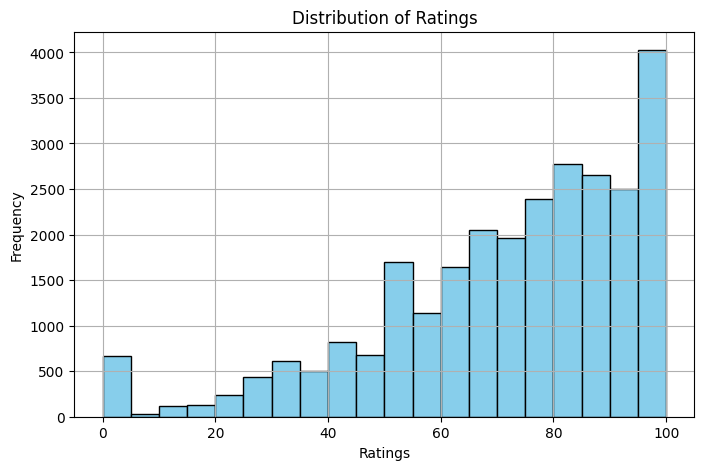

In [895]:
plt.figure(figsize=(8, 5))
plt.hist(data['ratings'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Average Playtime versus Ratings

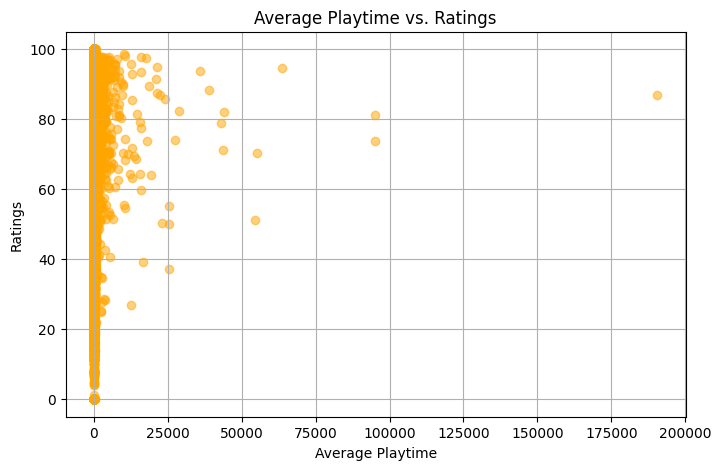

In [896]:
plt.figure(figsize=(8, 5))
plt.scatter(data['average_playtime'], data['ratings'], alpha=0.5, color='orange')
plt.title('Average Playtime vs. Ratings')
plt.xlabel('Average Playtime')
plt.ylabel('Ratings')
plt.grid(True)
plt.show()

## Number of Games released over time

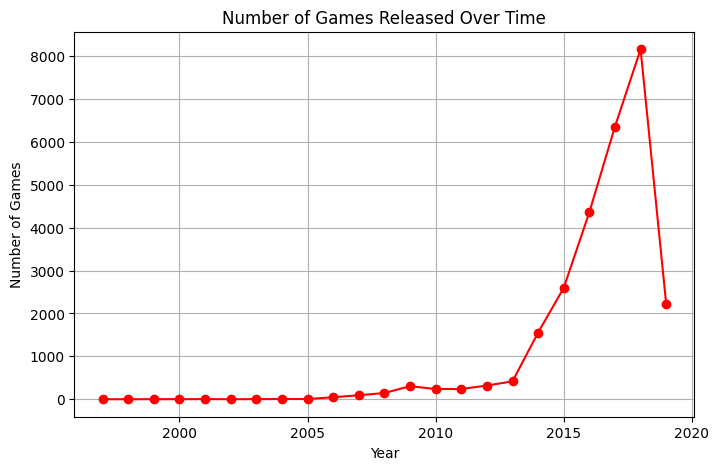

In [897]:
plt.figure(figsize=(8, 5))
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data['release_date'].dt.year
games_per_year = data.groupby('release_year').size()
games_per_year.plot(marker='o', color='red')
plt.title('Number of Games Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.grid(True)
plt.show()

## Top Genres Distribution

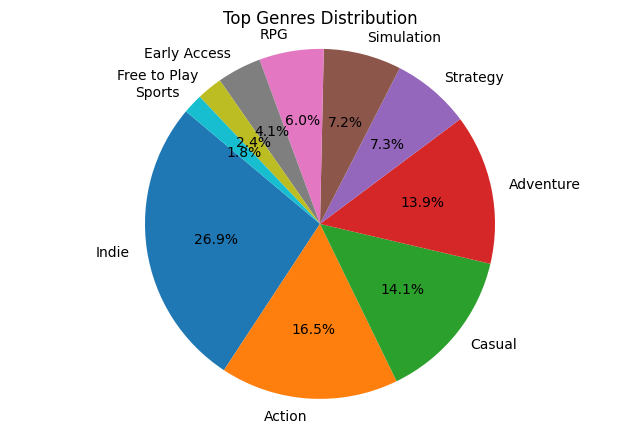

In [898]:
# Count occurrences of each genre
genre_counts = data['genres'].str.split(';').explode().value_counts()
# Select the top 10 genres
top_genres = genre_counts.head(10)

# Create a pie chart for top genres
plt.figure(figsize=(8, 5))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Genres Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## Top publishers and developers

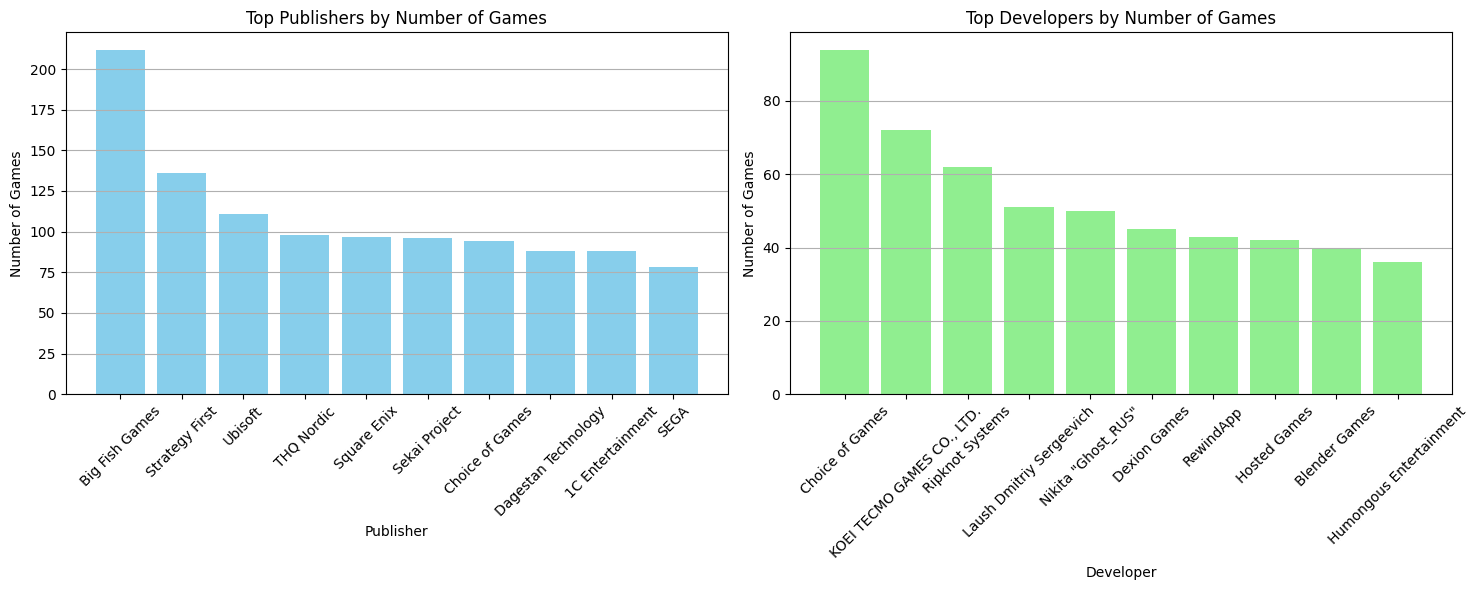

In [899]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Top Publishers
top_publishers = data['publishers'].value_counts().head(10)
axs[0].bar(top_publishers.index, top_publishers.values, color='skyblue')
axs[0].set_title('Top Publishers by Number of Games')
axs[0].set_xlabel('Publisher')
axs[0].set_ylabel('Number of Games')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Top Developers
top_developers = data['developers'].value_counts().head(10)
axs[1].bar(top_developers.index, top_developers.values, color='lightgreen')
axs[1].set_title('Top Developers by Number of Games')
axs[1].set_xlabel('Developer')
axs[1].set_ylabel('Number of Games')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()

## High Average Rating with Low number of ratings

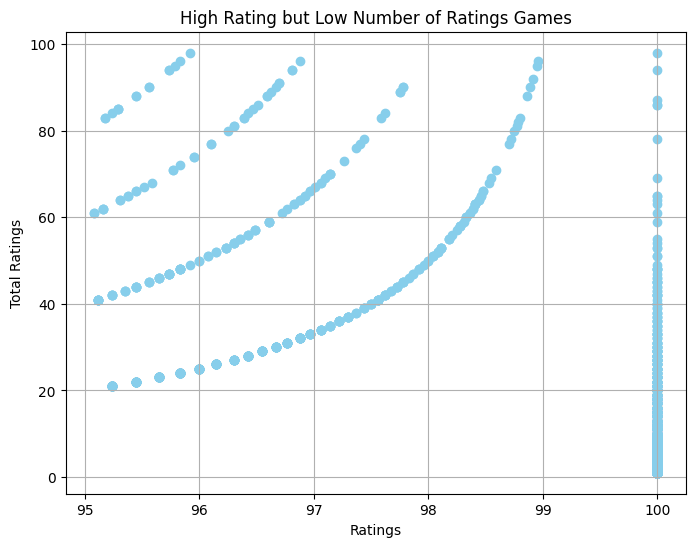

In [900]:
# Define thresholds for high ratings and low numbers of ratings
high_rating_threshold = 95  
low_ratings_threshold = 100 
filtered_df = data[(data['ratings'] > high_rating_threshold) & (data['totalRatings'] < low_ratings_threshold)]

# Create a scatter plot for high average rating but low number of ratings games
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['ratings'], filtered_df['totalRatings'], color='skyblue')
plt.title('High Rating but Low Number of Ratings Games')
plt.xlabel('Ratings')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

# Data preprocessing
In this section we begin by dealing with the most glaring problem we noticed with the dataset: the high rated games with small number of ratings.

These games would easily affect the accuracy of our models as they simply have not stood the test of enough users. 

In the meantime, we hoped to tackle another common issue amongst any given rating system. 

How to compare close average ratings but with a very large discrepancy in total number of ratings? 

Is a rating of 96 with 50 reviews a stronger candidate than a game with a rating of 93 but with 200 reviews?

## Weighted rating
We thus introduced a new column feature "weighted rating" which takes into account the total number of ratings and compares it to the 50th percentile of total ratings.

It uses the following formula: $total / (total + m) * avg + (m / total + m) * C$

In essence, this formula normalizes all our rated games. It removes outliers that do not satisfy the minimum threshold of total ratings.

In [901]:
# Determine the minimum number of ratings required to be listed, using the 50th percentile as a threshold
m = data['totalRatings'].quantile(0.50)

# Calculate C, the mean rating across all games
C = data['ratings'].mean()

# Apply the weighted rating formula
data['weighted_rating'] = (data['totalRatings'] / (data['totalRatings'] + m) * data['ratings']) + (m / (data['totalRatings'] + m) * C)

# Display the first few rows to verify the calculation
data[['name', 'ratings', 'totalRatings', 'weighted_rating']]
sorted = data.sort_values(by=['totalRatings'], ascending=False)
new = sorted[sorted['totalRatings']> m]
new[['appid', 'name','ratings', 'weighted_rating', 'totalRatings']]

,appid,name,ratings,weighted_rating,totalRatings
25,730,Counter-Strike: Global Offensive,86.80,86.799819,3046717
22,570,Dota 2,85.87,85.869484,1005586
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,50.46,50.460768,983260
19,440,Team Fortress 2,93.81,93.808536,549915
2478,271590,Grand Theft Auto V,70.26,70.260091,468369
...,...,...,...,...,...
18763,755670,Sleep Tight,86.49,79.071959,37
9942,500320,A Tale of Caos: Overture,70.27,70.850863,37
7473,423440,Choice of Kung Fu,94.59,83.177438,37
20540,805450,Derrek Quest V Regression,48.65,59.892780,37


## Average Rating vs Weighted Rating

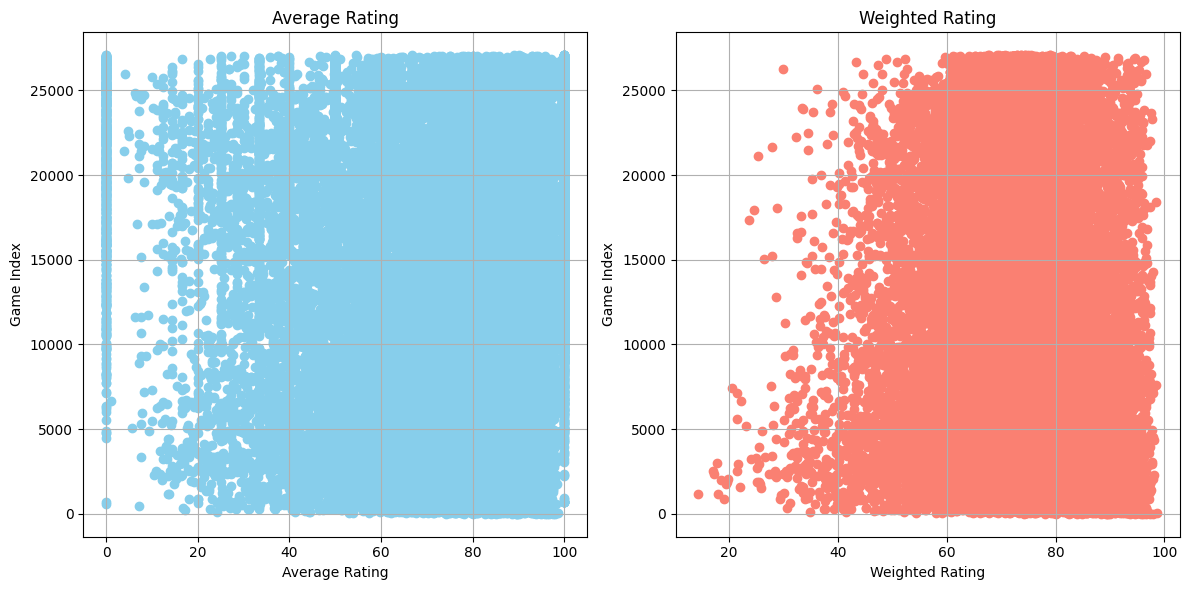

In [902]:
# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average rating
axs[0].scatter(data['ratings'], range(len(data)), color='skyblue', label='Average Rating')
axs[0].set_title('Average Rating')
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Game Index')
axs[0].grid(True)

# Plot weighted rating
axs[1].scatter(data['weighted_rating'], range(len(data)), color='salmon', label='Weighted Rating')
axs[1].set_title('Weighted Rating')
axs[1].set_xlabel('Weighted Rating')
axs[1].set_ylabel('Game Index')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Game genres feature classification
In this section, we decided to convert each genre to a numerical value using a method called frequency based encoding.

We keep track of all genres encountered and aggregate them together in a dictionary. A game with multiple genres will hold a value according to its most popular genre.

In [903]:
genres_series = data['genres'].str.split(';').explode()
num_genres = genres_series.nunique()
print("Number of unique genres:", num_genres)

Number of unique genres: 29


In [904]:
# Frequency-Based Encoding
genre_counts = data['genres'].str.split(';').explode().value_counts()
genre_mapping = {genre: i for i, genre in enumerate(genre_counts.index)}
data['encoded_genre'] = data['genres'].str.split(';').str[0].map(genre_mapping)

print("Genre Mapping for Frequency-Based Encoding:")
for genre, encoding in genre_mapping.items():
    print(f"{genre}: {encoding}")



Genre Mapping for Frequency-Based Encoding:
Indie: 0
Action: 1
Casual: 2
Adventure: 3
Strategy: 4
Simulation: 5
RPG: 6
Early Access: 7
Free to Play: 8
Sports: 9
Racing: 10
Violent: 11
Massively Multiplayer: 12
Gore: 13
Nudity: 14
Sexual Content: 15
Utilities: 16
Design & Illustration: 17
Animation & Modeling: 18
Education: 19
Video Production: 20
Software Training: 21
Audio Production: 22
Web Publishing: 23
Game Development: 24
Photo Editing: 25
Accounting: 26
Documentary: 27
Tutorial: 28


In [905]:
data

,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,totalRatings,average_playtime,median_playtime,num_owners,release_year,weighted_rating,encoded_genre
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,127873,17612,317,10000000-20000000,2000,97.382699,1
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,3951,277,62,5000000-10000000,1999,83.866843,1
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,3814,187,34,5000000-10000000,2003,89.390640,1
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,1540,258,184,5000000-10000000,2001,82.403885,1
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,5538,624,415,5000000-10000000,1999,94.649179,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2.09,2019-04-24,0,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,100.00,3,0,0,0-20000,2019,73.644179,3
27071,1065570,Cyber Gun,1.69,2019-04-23,0,BekkerDev Studio,Semyon Maximov,Single-player,Action;Adventure;Indie,88.89,9,0,0,0-20000,2019,74.936288,1
27072,1065650,Super Star Blast,3.99,2019-04-24,0,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,0.00,1,0,0,0-20000,2019,69.516837,1
27073,1066700,New Yankee 7: Deer Hunters,5.19,2019-04-17,0,Alawar Entertainment,Yustas Game Studio,Single-player;Steam Cloud,Adventure;Casual;Indie,100.00,2,0,0,0-20000,2019,72.950605,3


## Elbow Method ##
We used the elbow to determine what is the optimal number of clusters for the weighted ratings
Basically we wanted to categorize the weighted ratings, so we chose k_means in order to categorize the ratings and based on the elbow method the optimal number for k is 3

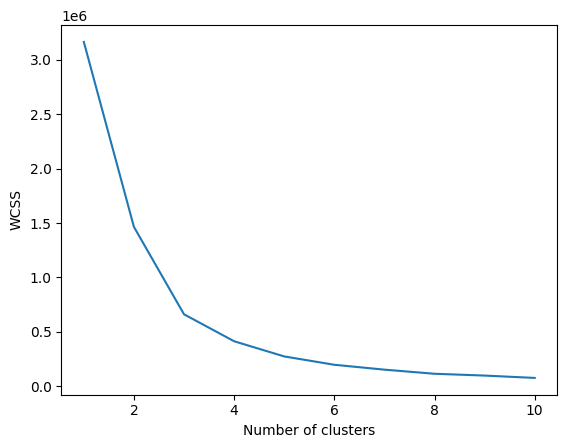

In [906]:
# We are using the elbow method to determine what is the optimal number of clusters for weighted rating
# Isolating the 'weighted_rating' column for K-means
X = data[['weighted_rating']]
#WCSS (Within-Cluster Sum of Square)
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state= 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

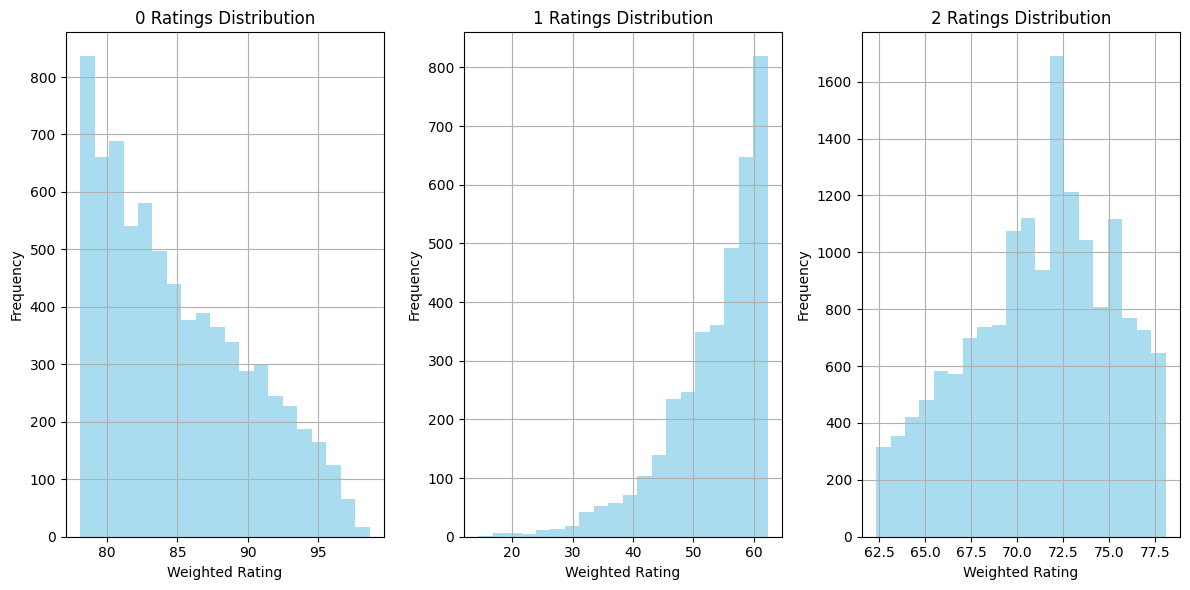

In [907]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
data["labels"] =  kmeans.labels_

num_categories = 3
labels = [0, 1, 2]
plt.figure(figsize=(12, 6))
for i, category in enumerate(labels):
    plt.subplot(1, num_categories, i + 1)
    category_data = data[data['labels'] == category]
    plt.hist(category_data['weighted_rating'], bins=20, color='skyblue', alpha=0.7)
    plt.title(f'{category} Ratings Distribution')
    plt.xlabel('Weighted Rating')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Developer preprocessing
We will use the developers' popularity by calculating the number of games each developer did. This indication can give us insight about how big developers in th industry can affect the rating of the game.
In the case there are mutiple developers for the same game we will get the average of the developers popularity

In [908]:
data["developers_list"] = data["developers"].str.split(';')
exploded_data =  data.explode('developers_list')
developer_counts_exploded = exploded_data["developers_list"].value_counts()
exploded_data['developer_freq'] = exploded_data['developers_list'].map(developer_counts_exploded)
avg_developer_freq = exploded_data.groupby(exploded_data.index).agg({'developer_freq': 'mean'})
data["avg_developer_freq"] = avg_developer_freq["developer_freq"]
data


,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,totalRatings,average_playtime,median_playtime,num_owners,release_year,weighted_rating,encoded_genre,labels,developers_list,avg_developer_freq
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,127873,17612,317,10000000-20000000,2000,97.382699,1,0,[Valve],27.0
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,3951,277,62,5000000-10000000,1999,83.866843,1,0,[Valve],27.0
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,3814,187,34,5000000-10000000,2003,89.390640,1,0,[Valve],27.0
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,1540,258,184,5000000-10000000,2001,82.403885,1,0,[Valve],27.0
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,5538,624,415,5000000-10000000,1999,94.649179,1,0,[Gearbox Software],11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2.09,2019-04-24,0,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,100.00,3,0,0,0-20000,2019,73.644179,3,2,[SHEN JIAWEI],1.0
27071,1065570,Cyber Gun,1.69,2019-04-23,0,BekkerDev Studio,Semyon Maximov,Single-player,Action;Adventure;Indie,88.89,9,0,0,0-20000,2019,74.936288,1,2,[Semyon Maximov],1.0
27072,1065650,Super Star Blast,3.99,2019-04-24,0,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,0.00,1,0,0,0-20000,2019,69.516837,1,2,[EntwicklerX],4.0
27073,1066700,New Yankee 7: Deer Hunters,5.19,2019-04-17,0,Alawar Entertainment,Yustas Game Studio,Single-player;Steam Cloud,Adventure;Casual;Indie,100.00,2,0,0,0-20000,2019,72.950605,3,2,[Yustas Game Studio],8.0


In [909]:
data["publisher_list"] = data["publishers"].str.split(';')
exploded_data =  data.explode('publisher_list')
developer_counts_exploded = exploded_data["publisher_list"].value_counts()
exploded_data['publisher_freq'] = exploded_data['publisher_list'].map(developer_counts_exploded)
avg_developer_freq = exploded_data.groupby(exploded_data.index).agg({'publisher_freq': 'mean'})
data["avg_publisher_freq"] = avg_developer_freq["publisher_freq"]
developer_counts_exploded


publisher_list
Big Fish Games        212
Strategy First        136
THQ Nordic            119
Ubisoft               114
Plug In Digital       111
                     ... 
Green Sawdust           1
EastFog Studios         1
Deep Voodoo Gaming      1
One More Game           1
SHEN JIAWEI             1
Name: count, Length: 14351, dtype: int64

## Average developer rating

### Developers average ratings

In [910]:
# Calculating the average rating for each developer
developer_avg_rating = data.groupby('developers')['weighted_rating'].mean().rename('developer_avg_rating')

# Joining the average rating back to the original dataframe
data = data.join(developer_avg_rating, on='developers')
data

,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,...,num_owners,release_year,weighted_rating,encoded_genre,labels,developers_list,avg_developer_freq,publisher_list,avg_publisher_freq,developer_avg_rating
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,...,10000000-20000000,2000,97.382699,1,0,[Valve],27.0,[Valve],30.0,89.015516
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,...,5000000-10000000,1999,83.866843,1,0,[Valve],27.0,[Valve],30.0,89.015516
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,...,5000000-10000000,2003,89.390640,1,0,[Valve],27.0,[Valve],30.0,89.015516
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,...,5000000-10000000,2001,82.403885,1,0,[Valve],27.0,[Valve],30.0,89.015516
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,...,5000000-10000000,1999,94.649179,1,0,[Gearbox Software],11.0,[Valve],30.0,81.578503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2.09,2019-04-24,0,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,100.00,...,0-20000,2019,73.644179,3,2,[SHEN JIAWEI],1.0,[SHEN JIAWEI],1.0,73.644179
27071,1065570,Cyber Gun,1.69,2019-04-23,0,BekkerDev Studio,Semyon Maximov,Single-player,Action;Adventure;Indie,88.89,...,0-20000,2019,74.936288,1,2,[Semyon Maximov],1.0,[BekkerDev Studio],3.0,74.936288
27072,1065650,Super Star Blast,3.99,2019-04-24,0,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,0.00,...,0-20000,2019,69.516837,1,2,[EntwicklerX],4.0,[EntwicklerX],4.0,68.274706
27073,1066700,New Yankee 7: Deer Hunters,5.19,2019-04-17,0,Alawar Entertainment,Yustas Game Studio,Single-player;Steam Cloud,Adventure;Casual;Indie,100.00,...,0-20000,2019,72.950605,3,2,[Yustas Game Studio],8.0,[Alawar Entertainment],37.0,74.941424


### Publishers average ratings

In [911]:
# Calculating the average rating for each developer
publisher_avg_rating = data.groupby('publishers')['weighted_rating'].mean().rename('publisher_avg_rating')

# Joining the average rating back to the original dataframe
data = data.join(publisher_avg_rating, on='publishers')

,appid,name,price,release_date,required_age,publishers,developers,categories,genres,ratings,...,release_year,weighted_rating,encoded_genre,labels,developers_list,avg_developer_freq,publisher_list,avg_publisher_freq,developer_avg_rating,publisher_avg_rating
0,10,Counter-Strike,7.19,2000-11-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,97.39,...,2000,97.382699,1,0,[Valve],27.0,[Valve],30.0,89.015516,89.382439
1,20,Team Fortress Classic,3.99,1999-04-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,83.98,...,1999,83.866843,1,0,[Valve],27.0,[Valve],30.0,89.015516,89.382439
2,30,Day of Defeat,3.99,2003-05-01,0,Valve,Valve,Multi-player;Valve Anti-Cheat enabled,Action,89.56,...,2003,89.390640,1,0,[Valve],27.0,[Valve],30.0,89.015516,89.382439
3,40,Deathmatch Classic,3.99,2001-06-01,0,Valve,Valve,Multi-player;Online Multi-Player;Local Multi-P...,Action,82.66,...,2001,82.403885,1,0,[Valve],27.0,[Valve],30.0,89.015516,89.382439
4,50,Half-Life: Opposing Force,3.99,1999-11-01,0,Valve,Gearbox Software,Single-player;Multi-player;Valve Anti-Cheat en...,Action,94.80,...,1999,94.649179,1,0,[Gearbox Software],11.0,[Valve],30.0,81.578503,89.382439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2.09,2019-04-24,0,SHEN JIAWEI,SHEN JIAWEI,Single-player;Steam Achievements,Adventure;Casual;Indie,100.00,...,2019,73.644179,3,2,[SHEN JIAWEI],1.0,[SHEN JIAWEI],1.0,73.644179,73.644179
27071,1065570,Cyber Gun,1.69,2019-04-23,0,BekkerDev Studio,Semyon Maximov,Single-player,Action;Adventure;Indie,88.89,...,2019,74.936288,1,2,[Semyon Maximov],1.0,[BekkerDev Studio],3.0,74.936288,74.410327
27072,1065650,Super Star Blast,3.99,2019-04-24,0,EntwicklerX,EntwicklerX,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,0.00,...,2019,69.516837,1,2,[EntwicklerX],4.0,[EntwicklerX],4.0,68.274706,68.274706
27073,1066700,New Yankee 7: Deer Hunters,5.19,2019-04-17,0,Alawar Entertainment,Yustas Game Studio,Single-player;Steam Cloud,Adventure;Casual;Indie,100.00,...,2019,72.950605,3,2,[Yustas Game Studio],8.0,[Alawar Entertainment],37.0,74.941424,74.449144


In [912]:
data_set = data[['avg_publisher_freq','avg_developer_freq','encoded_genre','average_playtime','median_playtime','publisher_avg_rating','developer_avg_rating']]
data_set

,avg_publisher_freq,avg_developer_freq,encoded_genre,average_playtime,median_playtime,publisher_avg_rating,developer_avg_rating
0,30.0,27.0,1,17612,317,89.382439,89.015516
1,30.0,27.0,1,277,62,89.382439,89.015516
2,30.0,27.0,1,187,34,89.382439,89.015516
3,30.0,27.0,1,258,184,89.382439,89.015516
4,30.0,11.0,1,624,415,89.382439,81.578503
...,...,...,...,...,...,...,...
27070,1.0,1.0,3,0,0,73.644179,73.644179
27071,3.0,1.0,1,0,0,74.410327,74.936288
27072,4.0,4.0,1,0,0,68.274706,68.274706
27073,37.0,8.0,3,0,0,74.449144,74.941424


In [913]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

label = data[["labels"]]
X_train, X_test, y_train, y_test = train_test_split(data_set,label,test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


c:\Users\3ezoy\anaconda3\envs\soen471\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.86
